# Visual Transformer with Linformer

Training Visual Transformer on *Dogs vs Cats Data*

* Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
* Base Code - https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/
* Efficient Attention Implementation - https://github.com/lucidrains/vit-pytorch#efficient-attention

## Import Libraries

In [67]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT


In [68]:
print(f"Torch: {torch.__version__}")

Torch: 2.0.1+cu117


In [69]:
class Config():
    training_dir = 'data4preTrained/train/'
    testing_dir = 'data4preTrained/test/'
    weights_dir = "weights/"
    train_batch_size = 64
    train_number_epochs = 20
# Create output dir if they're not exist
if not os.path.exists(Config.weights_dir):
    os.makedirs(Config.weights_dir)


In [70]:
# Training settings
batch_size = Config.train_batch_size
epochs = Config.train_number_epochs
lr = 3e-5
gamma = 0.7
seed = 42

In [71]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [72]:
device = 'cuda'

## Load Data

In [73]:
train_dir = Config.training_dir
test_dir = Config.testing_dir

In [74]:
train_list = glob.glob(os.path.join(train_dir,'class**.npy'))
test_list = glob.glob(os.path.join(test_dir, 'class**.npy'))

In [75]:
test_list

['data4preTrained/test/class2_cqtRGB_SNR=20_974.npy',
 'data4preTrained/test/class2_cqtRGB_SNR=20_644.npy',
 'data4preTrained/test/class1_cqtRGB_SNR=20_653.npy',
 'data4preTrained/test/class1_cqtRGB_SNR=20_31.npy',
 'data4preTrained/test/class2_cqtRGB_SNR=20_804.npy',
 'data4preTrained/test/class2_cqtRGB_SNR=20_719.npy',
 'data4preTrained/test/class0_cqtRGB_SNR=20_168.npy',
 'data4preTrained/test/class1_cqtRGB_SNR=20_214.npy',
 'data4preTrained/test/class0_cqtRGB_SNR=20_201.npy',
 'data4preTrained/test/class0_cqtRGB_SNR=20_787.npy',
 'data4preTrained/test/class0_cqtRGB_SNR=20_39.npy',
 'data4preTrained/test/class1_cqtRGB_SNR=20_783.npy',
 'data4preTrained/test/class2_cqtRGB_SNR=20_105.npy',
 'data4preTrained/test/class0_cqtRGB_SNR=20_112.npy',
 'data4preTrained/test/class2_cqtRGB_SNR=20_9.npy',
 'data4preTrained/test/class2_cqtRGB_SNR=20_265.npy',
 'data4preTrained/test/class2_cqtRGB_SNR=20_144.npy',
 'data4preTrained/test/class2_cqtRGB_SNR=20_96.npy',
 'data4preTrained/test/class0_cqt

In [76]:
test_data = np.load(train_list[0])
print(test_data.shape)

(96, 513, 3)


In [77]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 2556
Test Data: 766


In [78]:
# labels = [path.split('/')[-1].split('.')[0] for path in train_list]
# for lp in range(len(labels)):
#     if 'pureNoise' in labels[lp]:
#         labels[lp] = 'pureNoise'
#     elif 'class0' in labels[lp]:
#         labels[lp] = 'class0'
#     elif 'class1' in labels[lp]:
#         labels[lp] = 'class1'
#     elif 'class2' in labels[lp]:
#         labels[lp] = 'class2'
# print(labels)    

labels = [path.split('/')[-1].split('.')[0] for path in train_list]
for lp in range(len(labels)):
    # if 'pureNoise' in labels[lp]:
    #     labels[lp] = 'pureNoise'
    if 'class0' in labels[lp]:
        labels[lp] = 'class0'
    elif 'class1' in labels[lp]:
        labels[lp] = 'class1'
    elif 'class2' in labels[lp]:
        labels[lp] = 'class2'
print(labels)    

['class1', 'class1', 'class2', 'class2', 'class1', 'class0', 'class0', 'class1', 'class1', 'class1', 'class0', 'class0', 'class0', 'class0', 'class2', 'class0', 'class0', 'class2', 'class2', 'class0', 'class0', 'class1', 'class0', 'class1', 'class2', 'class0', 'class0', 'class0', 'class0', 'class1', 'class2', 'class0', 'class0', 'class1', 'class2', 'class0', 'class1', 'class1', 'class2', 'class0', 'class1', 'class1', 'class1', 'class1', 'class0', 'class2', 'class1', 'class0', 'class2', 'class2', 'class1', 'class2', 'class0', 'class2', 'class2', 'class0', 'class1', 'class0', 'class1', 'class2', 'class1', 'class1', 'class2', 'class0', 'class2', 'class1', 'class2', 'class1', 'class0', 'class1', 'class1', 'class0', 'class2', 'class0', 'class0', 'class0', 'class1', 'class0', 'class0', 'class1', 'class1', 'class0', 'class2', 'class2', 'class2', 'class2', 'class2', 'class1', 'class0', 'class2', 'class1', 'class0', 'class1', 'class1', 'class1', 'class0', 'class1', 'class2', 'class1', 'class2',

## Random Plots

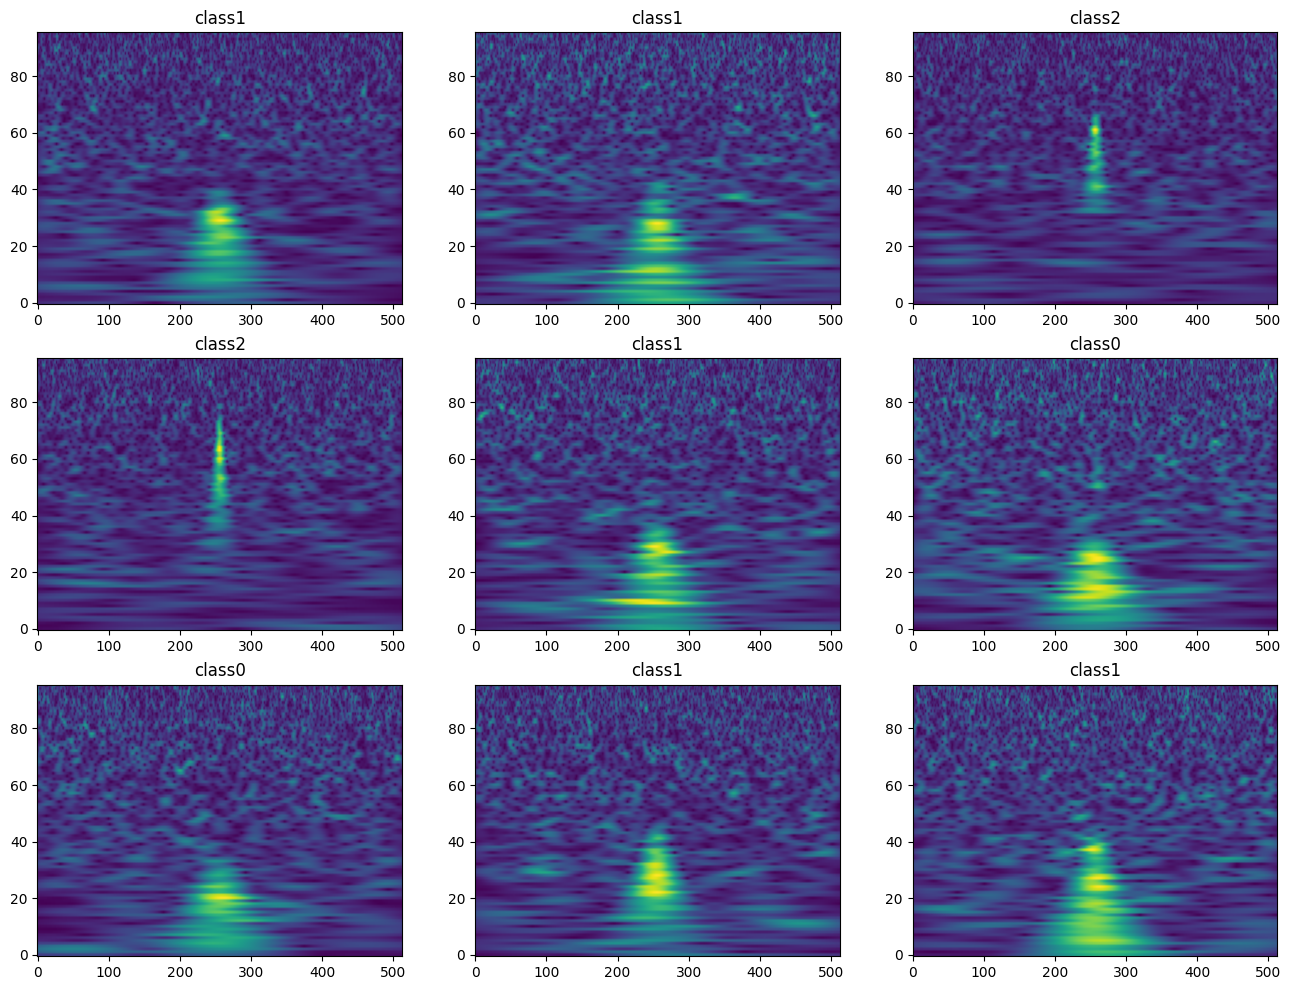

In [79]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    img = np.load(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img,origin='lower',aspect='auto')
    


## Split

In [80]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.1,
                                          stratify=labels,
                                          random_state=seed)

/home/guoyiyang/.conda/envs/ml/lib/python3.8/site-packages/sklearn/model_selection/_split.py:1462: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/home/guoyiyang/.conda/envs/ml/lib/python3.8/site-packages/sklearn/model_selection/_split.py:1462: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If y

In [81]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 2300
Validation Data: 256
Test Data: 766


## Image Augmentation

In [82]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        # transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        # transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        # transforms.ToTensor(),
    ]
)


## Load Datasets

In [98]:



class stationaryDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = np.load(img_path)

        img = torch.tensor(img).permute(2,0,1)
        # print(img.shape)
        img_transformed = self.transform(img).float()

        # if 'pureNoise' in img_path:
        #     label = 0
        for classNum in range(3):
            if 'class'+str(classNum) in img_path:
                label = classNum
        print(label)
       
        return img_transformed, label


In [99]:
train_data = stationaryDataset(train_list, transform=train_transforms)
valid_data = stationaryDataset(valid_list, transform=test_transforms)
test_data = stationaryDataset(test_list, transform=test_transforms)

# refWGNpath = '/home/guoyiyang/github_repo/vit-pytorch/examples/data4preTrained/test/pureNoise_cqtRGB_SNR=1_3.npy'
# refWGNinTensor = np.load(refWGNpath)
# refWGNinTensor = torch.tensor(refWGNinTensor).permute(2,0,1).float()

# train_data = stationaryDataset(refWGNinTensor,train_list, transform=train_transforms)
# valid_data = stationaryDataset(refWGNinTensor,valid_list, transform=test_transforms)
# test_data = stationaryDataset(refWGNinTensor,test_list, transform=test_transforms)

In [100]:
train_data[3]

/home/guoyiyang/.conda/envs/ml/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(tensor([[[0.2741, 0.2740, 0.2740,  ..., 0.2670, 0.2671, 0.2671],
          [0.2741, 0.2737, 0.2737,  ..., 0.2650, 0.2655, 0.2655],
          [0.2740, 0.2734, 0.2733,  ..., 0.2627, 0.2636, 0.2636],
          ...,
          [0.2525, 0.2456, 0.2459,  ..., 0.2363, 0.2037, 0.2013],
          [0.2326, 0.2250, 0.2191,  ..., 0.2519, 0.2176, 0.2055],
          [0.2158, 0.2075, 0.1964,  ..., 0.2650, 0.2293, 0.2091]],
 
         [[0.1998, 0.2003, 0.2004,  ..., 0.2268, 0.2262, 0.2262],
          [0.1999, 0.2015, 0.2017,  ..., 0.2330, 0.2314, 0.2314],
          [0.2001, 0.2029, 0.2033,  ..., 0.2403, 0.2375, 0.2375],
          ...,
          [0.2529, 0.2756, 0.2604,  ..., 0.2993, 0.3788, 0.3838],
          [0.3068, 0.3268, 0.3330,  ..., 0.2583, 0.3484, 0.3745],
          [0.3523, 0.3701, 0.3943,  ..., 0.2238, 0.3227, 0.3667]],
 
         [[0.4989, 0.4993, 0.4993,  ..., 0.5135, 0.5133, 0.5133],
          [0.4990, 0.5000, 0.5001,  ..., 0.5164, 0.5157, 0.5157],
          [0.4991, 0.5008, 0.5010,  ...,

In [85]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [86]:
print(len(train_data), len(train_loader))

2300 36


In [87]:
print(len(valid_data), len(valid_loader))

256 4


## Efficient Attention

### Linformer

In [88]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

### Visual Transformer

In [89]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=3,
    transformer=efficient_transformer,
    channels=3,
).to(device)

### Training

In [90]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [91]:
epoch_loss_all = []
epoch_accuracy_all = []
epoch_valAcc_all = []
epoch_ValLoss_all = []

### Classification

In [92]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    epoch_loss_all.append(epoch_loss.cpu().detach().numpy())
    epoch_accuracy_all.append(epoch_accuracy)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
        epoch_ValLoss_all.append(epoch_val_loss.cpu().detach().numpy())
        epoch_valAcc_all.append(epoch_val_accuracy)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


  0%|          | 0/36 [00:00<?, ?it/s]

/home/guoyiyang/.conda/envs/ml/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


  0%|          | 0/36 [00:00<?, ?it/s]

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


KeyboardInterrupt: 

### Contrastive loss

Text(0.5, 1.0, 'Loss')

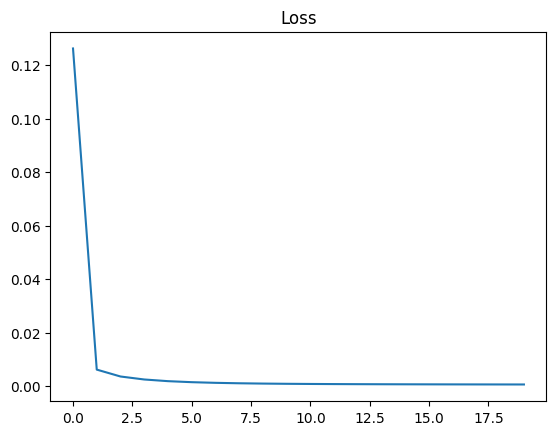

In [ ]:
# plot loss of the figure
plt.plot(range(epochs),epoch_loss_all)
plt.title('Loss')

In [ ]:

for lp in range(len(epoch_accuracy_all)):
    epoch_accuracy_all[lp] =epoch_accuracy_all[lp]
for lp in range(len(epoch_valAcc_all)):
    epoch_valAcc_all[lp] =epoch_valAcc_all[lp]


In [ ]:

for lp in range(len(epoch_accuracy_all)):
    epoch_accuracy_all[lp] =epoch_accuracy_all[lp].cpu()
for lp in range(len(epoch_valAcc_all)):
    epoch_valAcc_all[lp] =epoch_valAcc_all[lp].cpu()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<class 'type'>


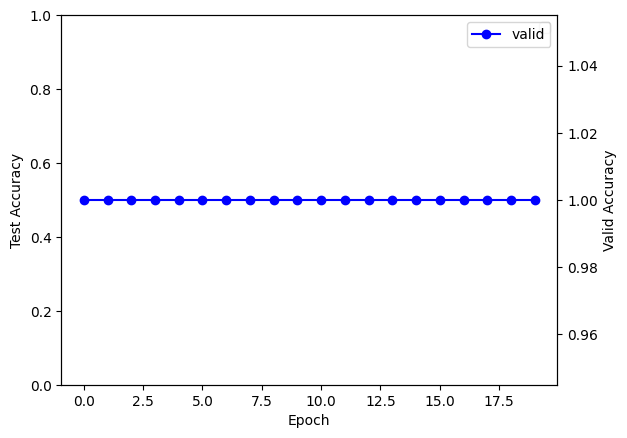

In [ ]:
# Plotting
print(type)
fig, ax1 = plt.subplots()
# ax1.plot(np.arange(len(epoch_accuracy_all)), epoch_accuracy_all, marker='o', color='red', label='train')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Test Accuracy', color='black')
ax1.tick_params('y', colors='black')
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(np.arange(len(epoch_valAcc_all)), epoch_valAcc_all, marker='o', color='blue', label='valid')
# ax2.plot(np.arange(len(epoch_loss_all)), epoch_loss_all, color='green', label='train_loss')
# ax2.plot(np.arange(len(epoch_ValLoss_all)), epoch_ValLoss_all, color='orange', label='valid_loss')
ax2.set_ylabel('Valid Accuracy', color='black')
ax2.tick_params('y', colors='black')
ax2.legend()

plt.show()

[tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.)]

In [ ]:
torch.save(model.state_dict(), Config.weights_dir+'epoch_{}.pth'.format(epoch))